In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import os
import json

import matplotlib.pyplot as plt

In [10]:
from tensorflow import keras
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv3D, MaxPooling3D, BatchNormalization, Activation
from keras.models import Sequential
from keras.regularizers import l2
from keras.optimizers import SGD, Adam

from sklearn.metrics import confusion_matrix

In [11]:
# Import Data
x_train = np.load('concat_data_small/x_train.npy')
y_train = np.load('concat_data_small/y_train.npy')

x_valid = np.load('concat_data_small/x_valid.npy')
y_valid = np.load('concat_data_small/y_valid.npy')

x_test = np.load('concat_data_small/x_test.npy')
y_test = np.load('concat_data_small/y_test.npy')

x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_valid /= 255
x_test /= 255

numClasses = int(np.max(y_train)+1)
y_train = keras.utils.to_categorical(y_train,numClasses)
y_valid = keras.utils.to_categorical(y_valid,numClasses)
y_test = keras.utils.to_categorical(y_test,numClasses)

inputShape = np.shape(x_train)[1:]

print(inputShape)
print(numClasses)

(3, 72, 128, 1)
6


In [12]:
#Define CNN
#Number of Filters
K = 20
#L2 regularization parameter
lam = .01
#Number of Neurons
N = 50
#Dropout Rate
r = 0.4
#Learning Rate
lr = 0.001

model = Sequential()
model.add(Conv3D(K, kernel_size=(3,3,3),strides=(1,1,1),padding='same',  
                 kernel_regularizer=l2(lam), input_shape = inputShape, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(r))
model.add(Conv3D(K, kernel_size=(3,3,3),strides=(1,1,1),padding='same',  
                 kernel_regularizer=l2(lam), input_shape = inputShape, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(1,2,2), strides=(1,2,2)))
model.add(Dropout(r))

#Fully Connected Layer
model.add(Flatten())
model.add(Dense(N, kernel_regularizer=l2(lam),use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(r))
model.add(Dense(int(numClasses), activation='softmax',use_bias=False))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 3, 72, 128, 20)    540       
_________________________________________________________________
batch_normalization_7 (Batch (None, 3, 72, 128, 20)    80        
_________________________________________________________________
activation_7 (Activation)    (None, 3, 72, 128, 20)    0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 3, 72, 128, 20)    0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 3, 72, 128, 20)    10800     
_________________________________________________________________
batch_normalization_8 (Batch (None, 3, 72, 128, 20)    80        
_________________________________________________________________
activation_8 (Activation)    (None, 3, 72, 128, 20)   

Train on 1563 samples, validate on 535 samples
Epoch 1/5
1563/1563 [==============================] - 286s 183ms/step - loss: 4.5293 - accuracy: 0.3666 - val_loss: 5.1733 - val_accuracy: 0.1794
Epoch 2/5
1563/1563 [==============================] - 285s 182ms/step - loss: 3.9967 - accuracy: 0.5189 - val_loss: 4.5958 - val_accuracy: 0.3402
Epoch 3/5
1563/1563 [==============================] - 285s 182ms/step - loss: 3.8884 - accuracy: 0.5483 - val_loss: 5.3799 - val_accuracy: 0.2411
Epoch 4/5
1563/1563 [==============================] - 286s 183ms/step - loss: 3.9448 - accuracy: 0.5745 - val_loss: 5.4714 - val_accuracy: 0.3065
Epoch 5/5
1563/1563 [==============================] - 285s 182ms/step - loss: 4.1055 - accuracy: 0.5829 - val_loss: 5.3081 - val_accuracy: 0.2299


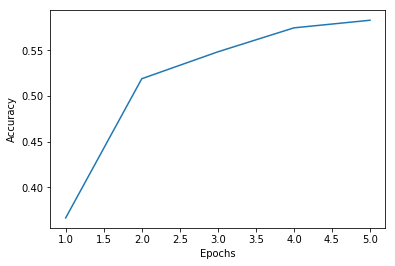

280/280 [==============================] - 8s 29ms/step
Test Accuracy: 0.18571428954601288


In [13]:
# Train the model and plot the validation error over time!
batchSize = 5
epochs = 5

#x_train = np.append(x_train,x_valid,axis=0)
#y_train = np.append(y_train,y_valid,axis=0)

history = model.fit(x_train, y_train,
                    batch_size=batchSize,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_valid,y_valid))
                    #validation_split = 0.2)                    

plt.plot(range(1,epochs+1), history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Now check the test error to see how we're really doing!
score = model.evaluate(x_test, y_test)
print('Test Accuracy:', score[1])

In [14]:
# Now check the test error to see how we're really doing!
#score = model.evaluate(x_test, y_test)
#print('Test Accuracy:', score[1])

predictions = model.predict(x_test)
predictions

array([[0.0211617 , 0.63355494, 0.06539244, 0.0564841 , 0.01331719,
        0.2100897 ],
       [0.10678709, 0.61116964, 0.00154571, 0.01644238, 0.13115475,
        0.13290036],
       [0.05121095, 0.64969426, 0.0035446 , 0.02284297, 0.06925072,
        0.20345654],
       ...,
       [0.02384834, 0.16352913, 0.0047459 , 0.01177577, 0.79154044,
        0.00456038],
       [0.03553499, 0.12213729, 0.00384949, 0.02408549, 0.80460846,
        0.00978425],
       [0.01574181, 0.02803002, 0.00202574, 0.00667073, 0.9425896 ,
        0.00494213]], dtype=float32)

In [15]:
#Confusion Matrix
matrix = confusion_matrix(y_test.argmax(axis=1),predictions.argmax(axis=1))
print(matrix)

[[20 15  0  0  0  6]
 [ 0 28  0  0 18  3]
 [ 3 26  0  0  0 23]
 [ 5  1  0  3  0 33]
 [33  4  0 11  0  8]
 [ 0 20  0  0 19  1]]


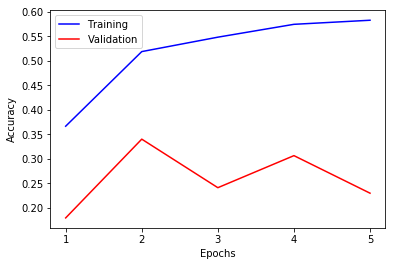

In [16]:
plt.plot(range(1,epochs+1), history.history['accuracy'],'b')
plt.plot(range(1,epochs+1),history.history['val_accuracy'],'r')
plt.xlabel('Epochs')
plt.xticks([1,2,3,4,5])
plt.ylabel('Accuracy')
plt.legend(['Training','Validation'])
plt.savefig('concatAccVEpoch.png')

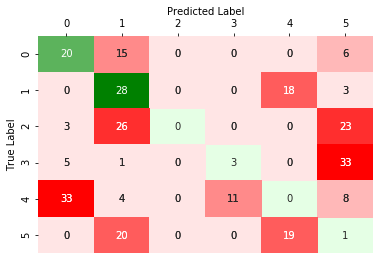

In [17]:
import seaborn as sn
import pandas as pd

# Plot the confusion matrix as a heatmap

sn.heatmap(matrix,cmap=sn.light_palette("green"),annot=True,cbar=False)
sn.heatmap(matrix,mask = np.eye(6),cmap=sn.light_palette("red"),annot=True,cbar=False)
plt.ylabel('True Label')
ax = plt.gca()
plt.xlabel('Predicted Label')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.savefig('concatConfuse.png')
